## Surprise Housing - Advanced Regression Assignment

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

#### The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

In [6]:
# Importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [8]:
# Importing csv file
housing = pd.read_csv("train.csv")
housing.head()
housing.tail()
housing.describe()
print(housing.shape)

(1460, 81)


In [9]:
# Finding % of null values in data set
(housing.isnull().sum()/len(housing)*100).sort_values(ascending=False)

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
FireplaceQu    47.260274
                 ...    
ExterQual       0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
SalePrice       0.000000
Length: 81, dtype: float64

In [10]:
# Dropping columns which has no predictive power
housing.drop(['Id'], axis = 1, inplace = True)

In [11]:
# Creating varaibles with high missing values (80% or more) to drop
missing_values = housing.columns[100*(housing.isnull().sum()/len(housing.index))> 80]
missing_values

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [12]:
# Dropping cols : very high missing values
housing.drop(missing_values,axis = 1, inplace = True)
# Firepalcequ has 47% missing valus hence dropping
housing.drop("FireplaceQu", axis = 1, inplace = True)

In [13]:
# Finding duplicate rows in data set
duplicate_rows = housing[housing.duplicated()]
duplicate_rows

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [14]:
# Deriving age of the house - deriving metrics
# Then dropping CurrentYear and YearBuilt Cols as not requried for further evaluation
housing['CurrentYear'] = datetime.datetime.now().year
housing["Age"] = housing['CurrentYear'] - housing['YearBuilt']
housing.drop(['CurrentYear', 'YearBuilt'], axis = 1, inplace = True)

In [15]:
#Creating categorical variable as num does not have any predictive power 
housing['OverallQual']=housing['OverallQual'].replace({ 10:'Very Excellent',
       9:'Excellent',
       8:'Very Good',
       7:'Good',
       6:'Above Average',
       5:'Average',
       4:'Below Average',
       3:'Fair',
       2:'Poor',
       1:'Very Poor'})
housing['OverallCond']=housing['OverallCond'].replace({ 10:'Very Excellent',
       9:'Excellent',
       8:'Very Good',
       7:'Good',
       6:'Above Average',
       5:'Average',
       4:'Below Average',
       3:'Fair',
       2:'Poor',
       1:'Very Poor'})
housing['MSSubClass']=housing['MSSubClass'].replace({20:'1-STORY 1946 & NEWER ALL STYLES',30:'1-STORY 1945 & OLDER',40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
       120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       150:'1-1/2 STORY PUD - ALL AGES',
       160:'2-STORY PUD - 1946 & NEWER',
       180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'})

In [16]:
# Missing value treatment - Identifying # of missing values and percentile for imputation
print(" NA values in LotFrontage    : ",housing.LotFrontage.isna().sum(),'\n',"NA values in MasVnrArea    : ",
      housing.MasVnrArea.isna().sum(),'\n',"NA values in GarageYrBlt    : ",
      housing.GarageYrBlt.isna().sum(),'\n')
housing[['LotFrontage','MasVnrArea','GarageYrBlt']].describe()


 NA values in LotFrontage    :  259 
 NA values in MasVnrArea    :  8 
 NA values in GarageYrBlt    :  81 



,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [17]:
# Replacing nan's with optimal value based on above table
housing['LotFrontage'] = housing.LotFrontage.fillna(housing.LotFrontage.median())
housing['MasVnrArea'] = housing.MasVnrArea.fillna(housing.MasVnrArea.mean())
housing['GarageYrBlt'] = housing.GarageYrBlt.fillna(housing.GarageYrBlt.mean())

In [18]:
# Identifying value counts for imputing most occuring value
print ("BsmtQual : ",'\n',housing.BsmtQual.value_counts())
print ("GarageFinish : ",'\n',housing.GarageFinish.value_counts())
print ("BsmtFinType1 : ",'\n',housing.BsmtFinType1.value_counts())
print ("GarageType : ",'\n',housing.GarageType.value_counts())
print ("BsmtExposure : ",'\n',housing.BsmtExposure.value_counts())
print ("MasVnrType : ",'\n',housing.MasVnrType.value_counts())
print ("GarageQual : ",'\n',housing.GarageQual.value_counts())
print ("GarageCond : ",'\n',housing.GarageCond.value_counts())
print ("BsmtFinType2 : ",'\n',housing.BsmtFinType2.value_counts())
print ("BsmtCond : ",'\n',housing.BsmtCond.value_counts())
print ("Electrical : ",'\n',housing.Electrical.value_counts())

BsmtQual :  
 TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64
GarageFinish :  
 Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64
BsmtFinType1 :  
 Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
GarageType :  
 Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
BsmtExposure :  
 No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
MasVnrType :  
 None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
GarageQual :  
 TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
GarageCond :  
 TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64
BsmtFinType2 :  
 Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
BsmtCond :  
 TA    1311
Gd      65
Fa      45
Po     

In [19]:
# Created function to replace values with most occurring values
def impute_missing_val(a,b):
    housing[a] = housing[a].fillna(b)

# using function to replace values with most occurring based on above table
impute_missing_val('BsmtQual','TA')
impute_missing_val('GarageFinish','Unf')
impute_missing_val('BsmtFinType1','Unf')
impute_missing_val('GarageType','Attchd')
impute_missing_val('BsmtExposure','No')
impute_missing_val('MasVnrType','None')
impute_missing_val('GarageQual','TA')
impute_missing_val('GarageCond','TA')
impute_missing_val('BsmtFinType2','Unf')
impute_missing_val('BsmtCond','TA')
impute_missing_val('Electrical','SBrkr')

In [20]:
# Used from https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart/48372659#48372659
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


In [21]:
# Creating function to plot columns
def count_f(a,b):
    ax = sns.countplot(a,data = b)
    add_value_labels(ax)

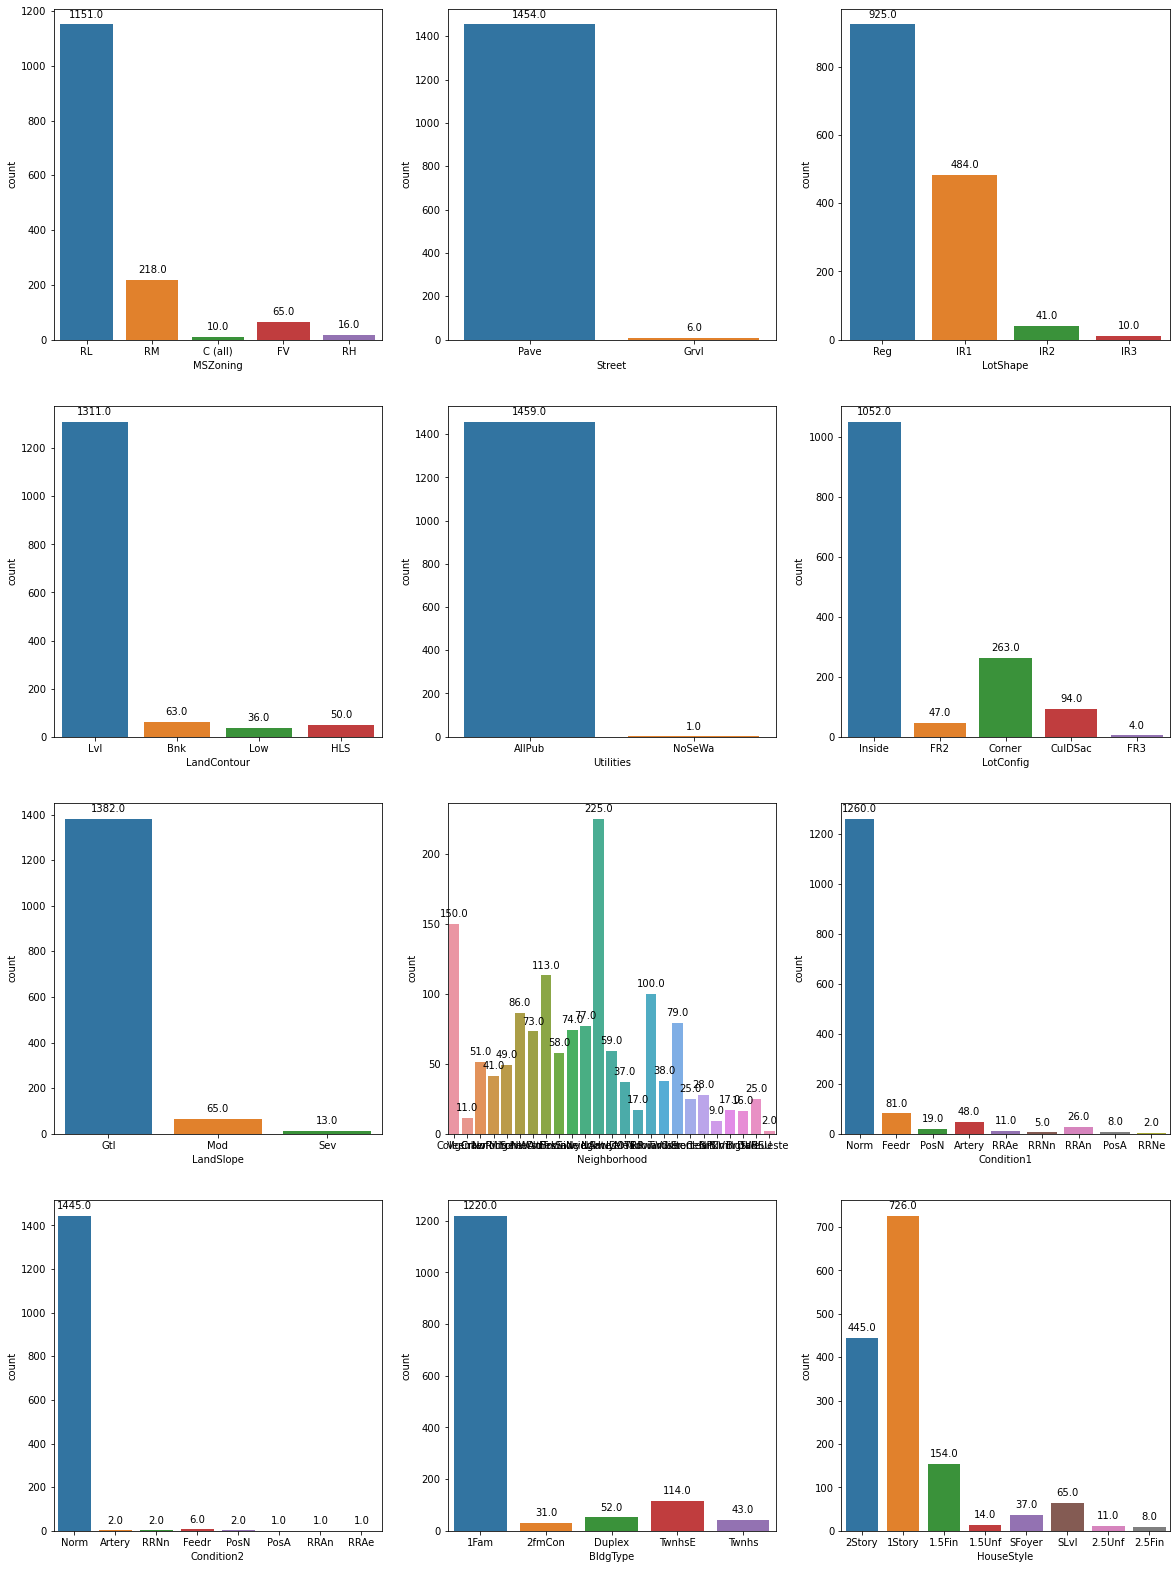

In [23]:
# Creating countplot to find skewed vols for dropping
plt.figure(figsize=(20, 28))
plt.subplot(4,3,1)
count_f('MSZoning', housing)
plt.subplot(4,3,2)
count_f('Street', housing)
plt.subplot(4,3,3)
count_f('LotShape', housing)
plt.subplot(4,3,4)
count_f('LandContour', housing)
plt.subplot(4,3,5)
count_f('Utilities', housing)
plt.subplot(4,3,6)
count_f('LotConfig', housing)
plt.subplot(4,3,7)
count_f('LandSlope', housing)
plt.subplot(4,3,8)
count_f('Neighborhood', housing)
plt.subplot(4,3,9)
count_f('Condition1', housing)
plt.subplot(4,3,10)
count_f('Condition2', housing)
plt.subplot(4,3,11)
count_f('BldgType', housing)
plt.subplot(4,3,12)
count_f('HouseStyle', housing)


In [17]:
# Since data is highly skewed hence dropping these columns
housing.drop(['MSZoning','Street','LandContour', 'Utilities','LandSlope','Condition1','Condition2','BldgType']
             , axis = 1, inplace = True)

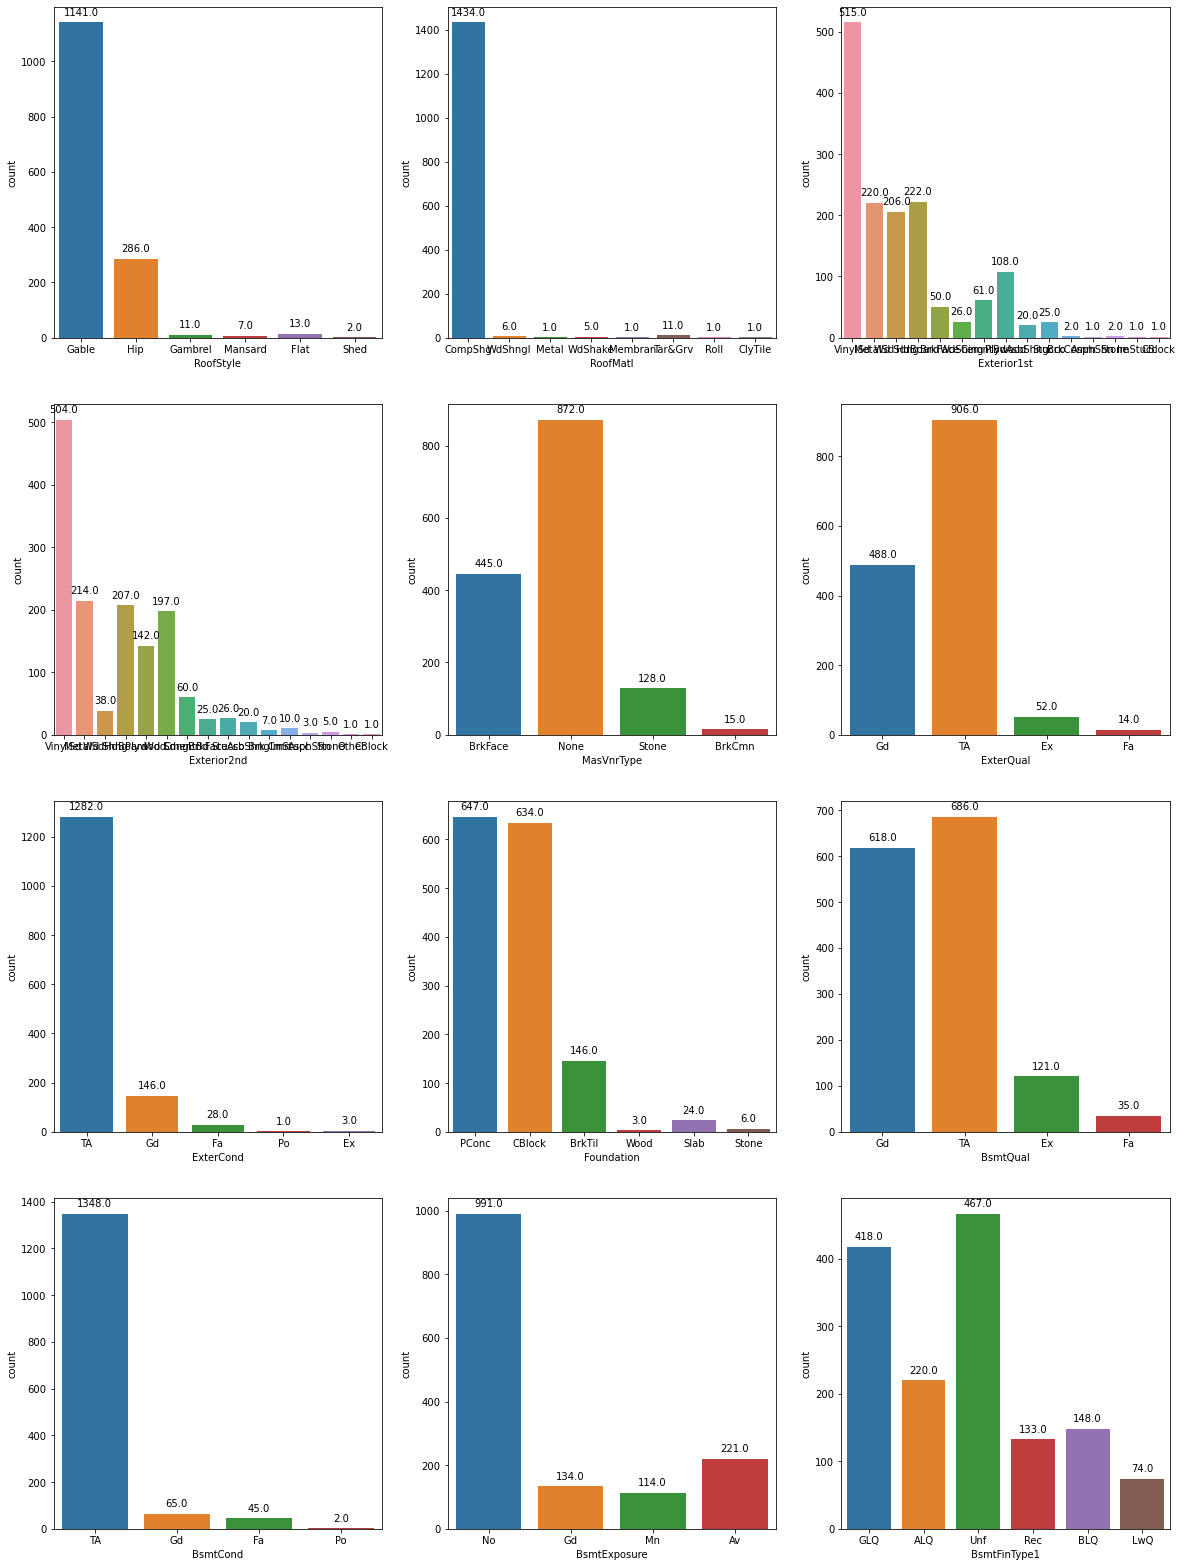

In [18]:
# Creating countplot to find skewed vols for dropping
plt.figure(figsize=(20, 28))
plt.subplot(4,3,1)
count_f('RoofStyle', housing)
plt.subplot(4,3,2)
count_f('RoofMatl', housing)
plt.subplot(4,3,3)
count_f('Exterior1st', housing)
plt.subplot(4,3,4)
count_f('Exterior2nd', housing)
plt.subplot(4,3,5)
count_f('MasVnrType', housing)
plt.subplot(4,3,6)
count_f('ExterQual', housing)
plt.subplot(4,3,7)
count_f('ExterCond', housing)
plt.subplot(4,3,8)
count_f('Foundation', housing)
plt.subplot(4,3,9)
count_f('BsmtQual', housing)
plt.subplot(4,3,10)
count_f('BsmtCond', housing)
plt.subplot(4,3,11)
count_f('BsmtExposure', housing)
plt.subplot(4,3,12)
count_f('BsmtFinType1', housing)

In [24]:
# Since data is highly skewed hence dropping these columns
housing.drop(['BsmtCond','ExterCond','MasVnrType', 'RoofMatl','RoofStyle'], axis = 1, inplace = True)

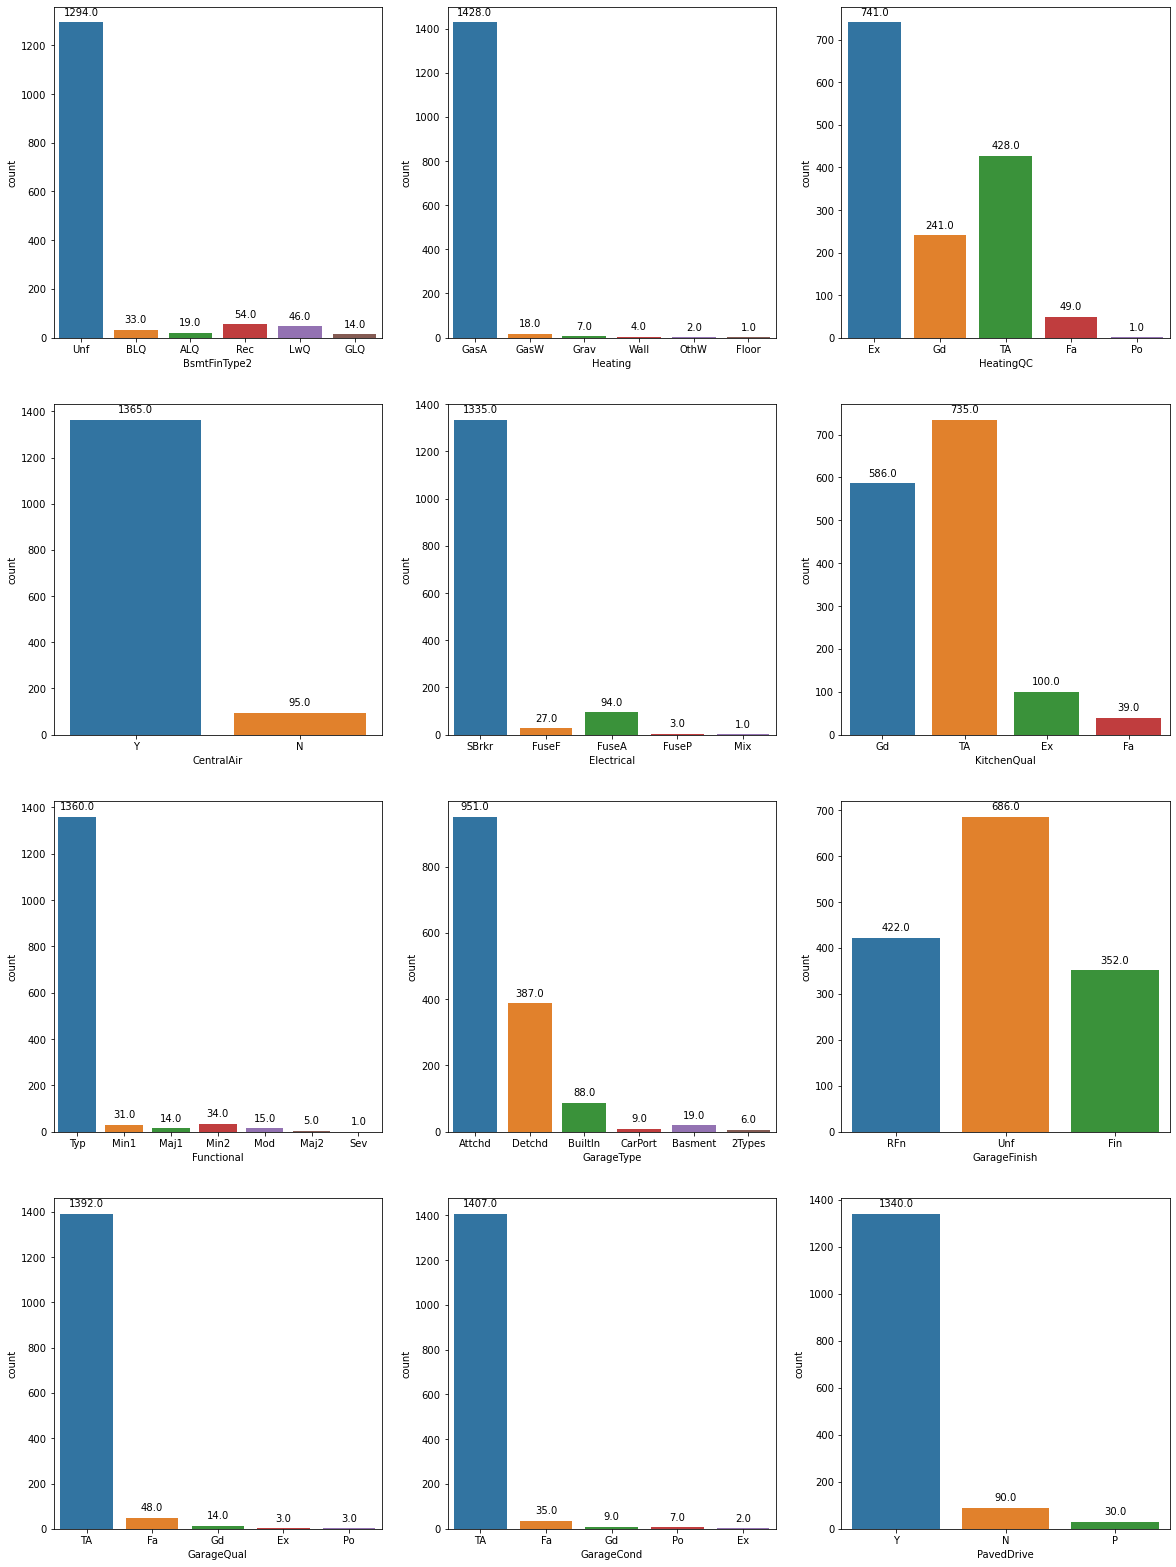

In [25]:
plt.figure(figsize=(20, 28))
plt.subplot(4,3,1)
count_f('BsmtFinType2', housing)
plt.subplot(4,3,2)
count_f('Heating', housing)
plt.subplot(4,3,3)
count_f('HeatingQC', housing)
plt.subplot(4,3,4)
count_f('CentralAir', housing)
plt.subplot(4,3,5)
count_f('Electrical', housing)
plt.subplot(4,3,6)
count_f('KitchenQual', housing)
plt.subplot(4,3,7)
count_f('Functional', housing)
plt.subplot(4,3,8)
count_f('GarageType', housing)
plt.subplot(4,3,9)
count_f('GarageFinish', housing)
plt.subplot(4,3,10)
count_f('GarageQual', housing)
plt.subplot(4,3,11)
count_f('GarageCond', housing)
plt.subplot(4,3,12)
count_f('PavedDrive', housing)

In [26]:
# Since data is highly skewed hence dropping these columns
housing.drop(['GarageQual','GarageCond','PavedDrive', 'Functional','Electrical','CentralAir','Heating','BsmtFinType2'], 
             axis = 1, inplace = True)

ValueError: Could not interpret input 'SaleType'

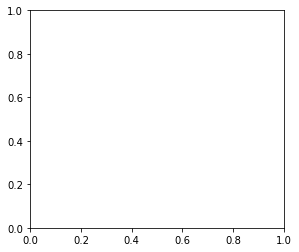

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
count_f('SaleType', housing)
plt.subplot(1,2,2)
count_f('SaleCondition', housing)

In [ ]:
# Since data is highly skewed hence dropping these columns
housing.drop(['SaleType','SaleCondition'], axis = 1, inplace = True)

In [28]:
# Creating cat and non cat variable to store columns based on dtype
cat_cols = []
num_cols = []

for col in list(housing):
    if housing[col].dtypes == 'object':
        cat_cols.append(col)  
    else:
        num_cols.append(col)
print('Categorical columns:\n',cat_cols)

print('Numerical columns:\n',num_cols)

Categorical columns:
 ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish']
Numerical columns:
 ['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'Age']


In [31]:
# Creating dummy variables
housing_dummy = pd.get_dummies(housing[cat_cols], drop_first=True)

In [32]:
#Concating the dataframe with dummies with the the original df
housing_concat = pd.concat([housing, housing_dummy], axis=1)

In [33]:
# Dropping original columns
housing_final = housing_concat.drop(cat_cols, axis = 1)
housing_final.shape

(1460, 195)

In [34]:
# Assiging cols to variables
X = housing_final.drop('SalePrice', axis=1)
y = housing_final['SalePrice']

In [35]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (1021, 194)
X_test Shape: (438, 194)
y_train Shape: (1021,)
y_test Shape: (438,)


In [36]:
# Scaling
scaler = StandardScaler()
#Scaling the numerical columns
num_cols_1 = num_cols.copy()
num_cols_1.remove('SalePrice')

In [37]:
# Fitting and Transforming training data set
X_train[num_cols_1] = scaler.fit_transform(X_train[num_cols_1])
X_train.head()

,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
210,-0.115302,-0.473765,-1.694350,-0.560537,0.043512,-0.293313,-0.374367,-0.430911,-0.765065,-0.787597,...,0,0,1,1,0,0,0,0,0,1
318,0.926898,-0.056845,0.390956,0.807462,1.160345,-0.293313,-0.454644,0.621579,0.511914,2.140556,...,0,1,0,1,0,0,0,0,1,0
239,-0.794998,-0.169324,-1.694350,-0.560537,-0.761296,-0.293313,0.171964,-0.712011,-0.930972,0.795996,...,0,0,1,0,0,0,0,1,0,1
986,-0.477806,-0.502297,0.875911,-0.560537,-0.963574,-0.293313,-0.175904,-1.256778,-0.420683,0.669584,...,0,1,0,1,0,0,0,0,0,1
1416,-0.432493,0.082905,-1.694350,-0.560537,-0.963574,-0.293313,0.475233,-0.620490,0.195183,1.611926,...,0,0,1,0,0,0,0,1,0,1


In [38]:
# Transforming test data set
X_test[num_cols_1] = scaler.transform(X_test[num_cols_1])
X_test.head()

,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
1436,-0.432493,-0.144189,-0.675945,-0.560537,0.361992,-0.293313,-0.704396,-0.430911,-0.765065,-0.787597,...,0,0,1,0,0,0,0,1,0,1
57,0.881585,0.112505,0.924407,-0.560537,-0.963574,-0.293313,0.660317,-0.439628,-0.775120,1.189021,...,0,1,0,1,0,0,0,0,1,0
780,-0.296554,-0.253368,0.536443,-0.357475,-0.963574,-0.293313,1.500998,0.381881,0.212779,-0.787597,...,0,0,1,1,0,0,0,0,0,0
382,0.428455,-0.120412,1.021398,-0.560537,-0.963574,-0.293313,0.836481,-0.267481,-0.576535,1.184425,...,0,1,0,1,0,0,0,0,1,0
1170,0.292515,-0.058786,-0.384972,-0.560537,0.159714,-0.293313,0.022559,0.074633,-0.126576,-0.787597,...,0,0,1,1,0,0,0,0,0,0


## Model Building & Evaluation - Ridge Regression

In [39]:
# list of alphas 
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 
                    8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()
# Performing cross validation
folds = 5
model = GridSearchCV(estimator = ridge,param_grid = params,scoring= 'r2',cv = folds,return_train_score=True,verbose = 1)            
model.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [40]:
# Cross valiadtion results
cv_results = pd.DataFrame(model.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.024240,0.017000,0.009358,0.006061,0.0001,{'alpha': 0.0001},0.863256,0.604312,0.756322,0.864949,...,0.788615,0.100712,26,0.917205,0.947142,0.918759,0.913754,0.920144,0.923401,0.012060
1,0.013896,0.007281,0.009986,0.006015,0.001,{'alpha': 0.001},0.863356,0.604559,0.756330,0.865049,...,0.788732,0.100668,25,0.917205,0.947142,0.918758,0.913754,0.920144,0.923401,0.012060
2,0.010211,0.008240,0.009390,0.007667,0.01,{'alpha': 0.01},0.864058,0.606905,0.756424,0.865961,...,0.789763,0.100191,24,0.917193,0.947129,0.918757,0.913748,0.920135,0.923392,0.012058
3,0.014116,0.003017,0.009396,0.007672,0.05,{'alpha': 0.05},0.865627,0.615434,0.756922,0.868989,...,0.792969,0.098070,22,0.917063,0.946914,0.918732,0.913632,0.919994,0.923267,0.012015
4,0.012825,0.005339,0.006295,0.007710,0.1,{'alpha': 0.1},0.866879,0.623656,0.757577,0.871706,...,0.795743,0.095802,21,0.916794,0.946453,0.918676,0.913367,0.919708,0.923000,0.011924


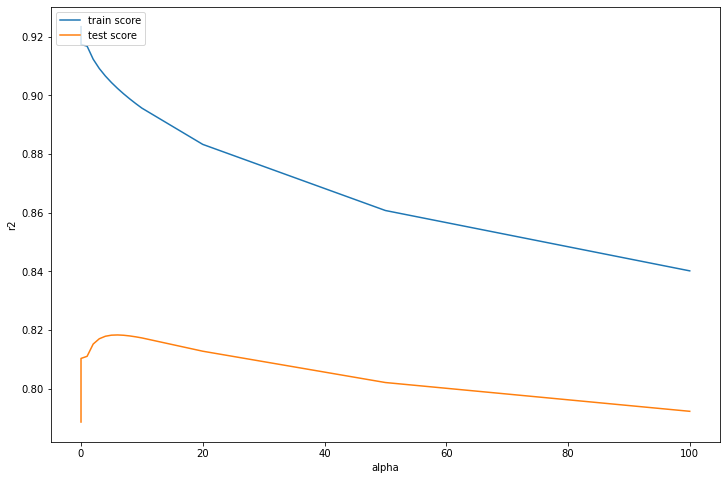

In [41]:
# plotting test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure (figsize = (12,8))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [42]:
# get the best estimator for lambda
model.best_estimator_

Ridge(alpha=6.0)

In [43]:
# Optimum Alpha - finding the coefficient values with lambda = 5
alpha = 5
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ -2992.21478405,   4876.11125673,   2168.29585101,   2216.69251772,
         -352.23187991,    354.65929313,   1592.43786661,   1331.41235989,
         4442.67790577,  17939.53217952,  -1137.50262555,  17898.78021468,
         4355.57532749,    572.82441008,   4065.18004773,   1419.85011493,
        -1535.06026546,  -4779.73901276,    891.73789593,   2970.50542724,
         1361.63378826,   9251.0414677 ,  -2652.40932748,   1360.36970851,
         -408.56398898,   1288.02318545,   1920.74054311,   1367.62641328,
         -755.09965934,    164.11917731,   -512.63106624,  -1313.92728367,
        -8095.97649036,    998.06118091,    578.3510306 ,   6416.11620604,
        -9296.35383392,   4199.68365792,  -1998.29689103,    916.93877547,
         2243.86799626,  -5597.04732526, -12701.29391724,   2773.80792744,
        -3840.79382391,   2977.40105335,   3480.96837233,   8152.84869613,
         6967.60207036,   9160.04035873,   4088.23715802,   8629.59966094,
         4103.66209279, -

In [44]:
print(ridge.score(X_train,y_train))
print(ridge.score(X_test,y_test))

0.8984088203306488
0.8638997978231966


In [45]:
# Ridge model parameters
model_parameters = list(sorted(ridge.coef_))
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 170546.746),
 ('LotFrontage', -43569.264),
 ('LotArea', -26170.554),
 ('YearRemodAdd', -22246.193),
 ('MasVnrArea', -20943.747),
 ('BsmtFinSF1', -20355.002),
 ('BsmtFinSF2', -20286.885),
 ('BsmtUnfSF', -17703.868),
 ('TotalBsmtSF', -15909.325),
 ('1stFlrSF', -14760.928),
 ('2ndFlrSF', -14732.776),
 ('LowQualFinSF', -14115.125),
 ('GrLivArea', -12701.294),
 ('BsmtFullBath', -12004.747),
 ('BsmtHalfBath', -11922.004),
 ('FullBath', -10800.132),
 ('HalfBath', -10380.698),
 ('BedroomAbvGr', -10373.977),
 ('KitchenAbvGr', -10160.603),
 ('TotRmsAbvGrd', -9895.214),
 ('Fireplaces', -9756.692),
 ('GarageYrBlt', -9604.853),
 ('GarageCars', -9404.823),
 ('GarageArea', -9296.354),
 ('WoodDeckSF', -9220.647),
 ('OpenPorchSF', -9167.224),
 ('EnclosedPorch', -8937.22),
 ('3SsnPorch', -8568.922),
 ('ScreenPorch', -8095.976),
 ('PoolArea', -7984.228),
 ('MiscVal', -7851.301),
 ('MoSold', -7352.984),
 ('YrSold', -7241.095),
 ('Age', -7118.023),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES'

## Model Building & Evaluation - Lasso

In [46]:
# Initializing lasso and assigning to variable
lasso = Lasso()

# cross validation
model = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [47]:
# Cross validation results
cv_results_l = pd.DataFrame(model.cv_results_)
cv_results_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.187353,0.012979,0.008568,0.007848,0.0001,{'alpha': 0.0001},0.863572,0.604418,0.754769,0.865108,...,0.788402,0.100834,27,0.917202,0.947141,0.918758,0.913754,0.920144,0.923400,0.01206
1,0.196965,0.005005,0.002404,0.004809,0.001,{'alpha': 0.001},0.863573,0.604419,0.754862,0.865109,...,0.788431,0.100834,26,0.917202,0.947141,0.918758,0.913754,0.920144,0.923400,0.01206
2,0.187243,0.015156,0.007034,0.006225,0.01,{'alpha': 0.01},0.863587,0.604435,0.755273,0.865124,...,0.788530,0.100811,25,0.917202,0.947141,0.918758,0.913754,0.920144,0.923400,0.01206
3,0.186276,0.017683,0.001600,0.003200,0.05,{'alpha': 0.05},0.863648,0.604503,0.755293,0.865189,...,0.788594,0.100817,24,0.917202,0.947141,0.918758,0.913754,0.920144,0.923400,0.01206
4,0.189194,0.007453,0.003129,0.006258,0.1,{'alpha': 0.1},0.863727,0.604585,0.755318,0.865268,...,0.788671,0.100825,23,0.917201,0.947140,0.918758,0.913753,0.920144,0.923399,0.01206


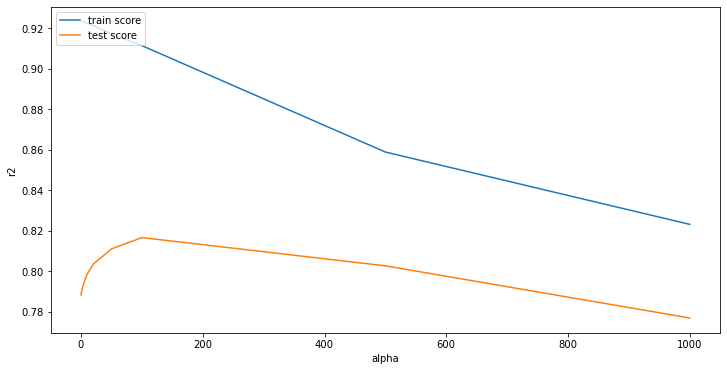

In [48]:

# plotting mean test and train  
cv_results_l['param_alpha'] = cv_results_l['param_alpha'].astype('float32')

# plotting
plt.figure(figsize=(12,6))
plt.plot(cv_results_l['param_alpha'], cv_results_l['mean_train_score'])
plt.plot(cv_results_l['param_alpha'], cv_results_l['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [49]:
# get the best estimator for lambda
model.best_estimator_

Lasso(alpha=100)

In [50]:
alpha =100

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train)

Lasso(alpha=100)

In [51]:
lasso.coef_

array([-2.86032000e+03,  4.65547651e+03,  3.01184594e+03,  1.91262725e+03,
       -0.00000000e+00,  0.00000000e+00,  1.61574647e+03,  1.67301323e+03,
        0.00000000e+00,  9.62871205e+03, -1.78102346e+03,  2.47264483e+04,
        4.48468082e+03,  7.64494875e+02,  3.76936283e+03,  8.82398853e+02,
       -1.07123358e+03, -4.80070710e+03,  0.00000000e+00,  2.28320175e+03,
        4.32018031e+02,  9.10584627e+03, -2.25796310e+03,  1.05659105e+03,
       -3.69043319e+01,  1.16961366e+03,  1.80204799e+03,  1.43722312e+03,
       -1.68205260e+03,  0.00000000e+00, -1.54830690e+02, -1.07155762e+03,
       -9.21349194e+03,  0.00000000e+00, -0.00000000e+00,  5.87077379e+03,
       -0.00000000e+00,  0.00000000e+00, -1.10488550e+03, -0.00000000e+00,
        0.00000000e+00, -3.00469764e+03, -3.37435561e+03,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.38757152e+03, -0.00000000e+00,  0.00000000e+00,
        2.42279467e+02, -

In [52]:
y_pred_ridge_train = ridge.predict(X_train)
y_pred_lasso_train = lasso.predict(X_train)

Train dataset


Text(0.5, 1.0, 'Error disribution, lasso regression')

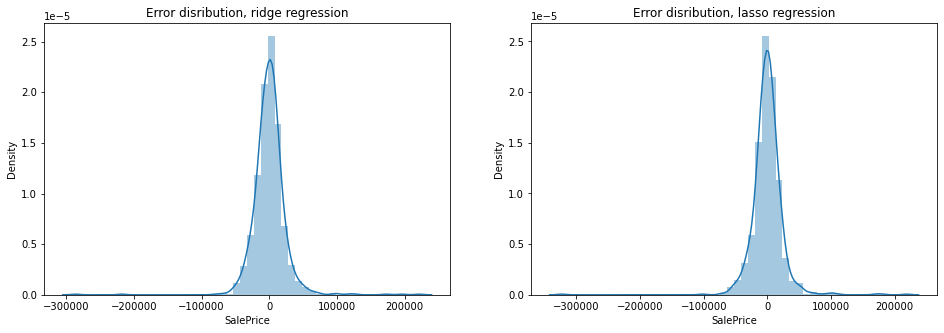

In [53]:
# Error distribution
print('Train dataset')
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
sns.distplot((y_train - y_pred_ridge_train), bins = 50)
plt.title('Error disribution, ridge regression')

plt.subplot(1, 2, 2)
sns.distplot((y_train - y_pred_lasso_train), bins = 50)
plt.title('Error disribution, lasso regression')

In [54]:
print('r2_score in train dataset')
print('r2_score for ridge:', r2_score(y_train, y_pred_ridge_train))
print('r2_score for lasso:', r2_score(y_train, y_pred_lasso_train))

r2_score in train dataset
r2_score for ridge: 0.8984088203306488
r2_score for lasso: 0.9031473790299227


In [55]:
y_pred_ridge_test = ridge.predict(X_test)
y_pred_lasso_test = lasso.predict(X_test)

Test dataset


Text(0.5, 1.0, 'Error disribution, lasso regression')

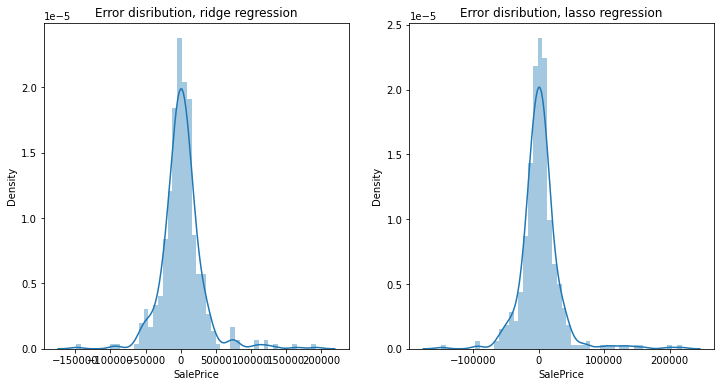

In [56]:
# Error Distribution
print('Test dataset')
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.distplot((y_test - y_pred_ridge_test), bins = 50)
plt.title('Error disribution, ridge regression')

plt.subplot(1, 2, 2)
sns.distplot((y_test - y_pred_lasso_test), bins = 50)
plt.title('Error disribution, lasso regression')

In [57]:
print('r2_score in train dataset:')
print('r2_score for ridge:', round(r2_score(y_train, y_pred_ridge_train), 2))
print('r2_score for lasso:', round(r2_score(y_train, y_pred_lasso_train), 2))

print('r2_score in test dataset:')
print('r2_score for ridge:', round(r2_score(y_test, y_pred_ridge_test), 2))
print('r2_score for lasso:', round(r2_score(y_test, y_pred_lasso_test), 2))

r2_score in train dataset:
r2_score for ridge: 0.9
r2_score for lasso: 0.9
r2_score in test dataset:
r2_score for ridge: 0.86
r2_score for lasso: 0.85


In [58]:
#lasso model parameters
model_param = list(sorted(lasso.coef_))
model_param.insert(0, lasso.intercept_)
model_param = [round(x, 3) for x in model_param]
cols = X.columns
cols = cols.insert(0, "constant")
var_coeff = list(zip(cols, model_param))
var_coeff

[('constant', 193222.717),
 ('LotFrontage', -224010.905),
 ('LotArea', -24957.441),
 ('YearRemodAdd', -20555.575),
 ('MasVnrArea', -20127.5),
 ('BsmtFinSF1', -19486.779),
 ('BsmtFinSF2', -17282.609),
 ('BsmtUnfSF', -16741.489),
 ('TotalBsmtSF', -16365.858),
 ('1stFlrSF', -15412.935),
 ('2ndFlrSF', -14460.664),
 ('LowQualFinSF', -13045.102),
 ('GrLivArea', -12677.008),
 ('BsmtFullBath', -10029.639),
 ('BsmtHalfBath', -9882.443),
 ('FullBath', -9812.163),
 ('HalfBath', -9213.492),
 ('BedroomAbvGr', -8018.84),
 ('KitchenAbvGr', -7532.835),
 ('TotRmsAbvGrd', -6544.926),
 ('Fireplaces', -6265.799),
 ('GarageYrBlt', -6262.757),
 ('GarageCars', -6127.243),
 ('GarageArea', -5975.499),
 ('WoodDeckSF', -4900.154),
 ('OpenPorchSF', -4800.707),
 ('EnclosedPorch', -4375.196),
 ('3SsnPorch', -3419.747),
 ('ScreenPorch', -3374.356),
 ('PoolArea', -3004.698),
 ('MiscVal', -2860.32),
 ('MoSold', -2503.356),
 ('YrSold', -2465.79),
 ('Age', -2257.963),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -1781.

In [59]:
#Features (including dummies) along with their coefficients
var_coeff = [x for x in var_coeff if abs(x[-1] != 0)]
var_coeff

[('constant', 193222.717),
 ('LotFrontage', -224010.905),
 ('LotArea', -24957.441),
 ('YearRemodAdd', -20555.575),
 ('MasVnrArea', -20127.5),
 ('BsmtFinSF1', -19486.779),
 ('BsmtFinSF2', -17282.609),
 ('BsmtUnfSF', -16741.489),
 ('TotalBsmtSF', -16365.858),
 ('1stFlrSF', -15412.935),
 ('2ndFlrSF', -14460.664),
 ('LowQualFinSF', -13045.102),
 ('GrLivArea', -12677.008),
 ('BsmtFullBath', -10029.639),
 ('BsmtHalfBath', -9882.443),
 ('FullBath', -9812.163),
 ('HalfBath', -9213.492),
 ('BedroomAbvGr', -8018.84),
 ('KitchenAbvGr', -7532.835),
 ('TotRmsAbvGrd', -6544.926),
 ('Fireplaces', -6265.799),
 ('GarageYrBlt', -6262.757),
 ('GarageCars', -6127.243),
 ('GarageArea', -5975.499),
 ('WoodDeckSF', -4900.154),
 ('OpenPorchSF', -4800.707),
 ('EnclosedPorch', -4375.196),
 ('3SsnPorch', -3419.747),
 ('ScreenPorch', -3374.356),
 ('PoolArea', -3004.698),
 ('MiscVal', -2860.32),
 ('MoSold', -2503.356),
 ('YrSold', -2465.79),
 ('Age', -2257.963),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -1781.

In [60]:
#Identifying important features, excluding dummies
final_var_list = []
for i in list(housing):
    for j in var_coeff:
        if i in j[0]:
            final_var_list.append(i)
            break
print(final_var_list)
print(len(final_var_list))

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Age']
46
